**Setup** <br> In this part the important packages and the data are going to be imported. The data is going to be preprocessed, so we are able to work with it.

In [1]:
# importing all the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.neural_network import MLPRegressor # neural network that is going to be used
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

In [7]:
# importing the data and splitting it into a train and test set to work with
# important!! use index_col=0 to read df otherwise pca starts at col 58
ped = pd.read_csv("data_clean_with_dummies.csv", index_col=0)

# beginning of the code, so everyone has the same data, for reproduceability
np.random.seed(1) 

# Define a new X with the squared feature k = 0.99, 57+46
X = np.array(ped[ped.columns[57:103]])

# Output to predict
y = ped["pedestrians count"]

# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)

**Hyperparameter tuning** <br> The different hyperparameters of the used function for our neural netwwork (MLPRegressor by sklearn) are being optimized. <br> 1. Establish a base scenario with the standard parameters to compare afterwards. <br> 2. Analyze the influence of the different parameters of MLPRegressor if every other parameter is in default. <br> 3. Trying to find the best parameters using RandomizedSearchCV and GridSearchCV using subsamples of the data.

*1. Establish Base Scenario*

In [5]:
# initialize a neural network with the default parameters 
nnet_base = MLPRegressor()

In [8]:
# scale the data to work so it is less sensitive to feature scaling 
scaler = StandardScaler()
# scale the inputs
scaler.fit(Xtrain)
Xtrain_scaled = scaler.transform(Xtrain)
# apply the same transformation to the test data to have meaningful results
scaler.fit(Xtest)
Xtest_scaled = scaler.transform(Xtest)
# scale the y different because we can't use standardscaler to a 1d array
mu, sigma = y.mean(), y.std()
ytest_scaled = (ytest - mu) / sigma
ytrain_scaled = (ytrain - mu) /sigma

In [98]:
# creating a dataframe to safe all results of mae and r2
comparison = pd.DataFrame(columns=["Model", "MAE_train", "MAE_test", "R2_train", "R2_test"])

# defining a function to fit the model and evaluate it
def model_fit_evaluate(display_name, model, traindataX_sc, traindatay_sc, testdataX_sc, testdatay_sc):
    global comparison
    # Fit the network to the scaled train data
    model.fit(traindataX_sc, traindatay_sc)

    # Make predictions
    ypred_train_scaled = model.predict(traindataX_sc)
    ypred_scaled = model.predict(testdataX_sc)

    # Reconstruct outputs and scale back predictions
    ytest = testdatay_sc * sigma + mu
    ytrain = traindatay_sc * sigma + mu
    ypred_train = ypred_train_scaled * sigma + mu
    ypred = ypred_scaled * sigma + mu
    # the network predicts negative values because it is not possible to put an activation function on the output layer
    # MLPRegressor uses the activation function only on the hidden layers
    # Negative Values make no sense in our case, therefore we fix it and tell the network that all negative values
    # should equal to zero
    ypred[ypred < 0] = 0

    # Compute the MAE
    mae_train = mean_absolute_error(ytrain, ypred_train)
    mae_test = mean_absolute_error(ytest, ypred)
    # Comute R^2
    r2_train = r2_score(ytrain, ypred_train)
    r2_test = r2_score(ytest, ypred)

    # adding the calculated reults to the dataframe
    row = pd.DataFrame(data=[[display_name,  mae_train, mae_test, r2_train, r2_test]],
    columns=["Model", "MAE_train", "MAE_test", "R2_train", "R2_test"])
    comparison = pd.concat([comparison, row])
    # merging results into dataframe and safe it as csv to add things later
    comparison = comparison.reset_index().drop(columns="index")
    comparison.to_csv("nnet_comparison.csv", sep=";", index=False)
    print(comparison)

In [10]:
model_fit_evaluate("Base Scenario", nnet_base, Xtrain_scaled, ytrain_scaled, Xtest_scaled, ytest_scaled)

           Model   MAE_train   MAE_test  R2_train   R2_test
0  Base Scenario  347.447001  456.57609  0.964814  0.942335


*2. Analyze the Influence of the Different Parameters*

In [ ]:
# conduncting the parameter analysis on the most used parameters for optimization
# how many hidden layers with how many neurons are we going to use
# 100 is the default value, other values chosen randomly to see the effect of more layers
hidden_layer_sizes = [(100,), (32, 64, 32), (64, 128, 64), (32, 64, 128, 64, 32)]
# activation function that is going to be used on the hidden layers, relu is the default value
activations = ["relu", "logistic", "tanh", "identity"]
# the solver which optimizes the weights, adam is the default value
solvers = ["sgd", "adam"]
# regularization: avoids overfitting, 0.0001 is the default value
alphas = np.linspace(0.00001, 0.001, 50)
# how high is the initial learing rate, 0.001 is the default value
learing_rate_inits = np.linspace(0.001, 0.01, 50)
# number of epochs, 200 is the default value
# often it doesn't converge then so we start at 1000
max_iters = range(1000, 2000, 20)

In [ ]:
# creating a dataframe to save the results
results = pd.DataFrame(columns=["Parameter", "ParameterValue", "MaeTrain", "MaeTest", "R2Train", "R2Test"])

# defining a function to do the analysis on the different parameters
def test_parameter(param, param_values, initialize_model):
    global results
    for param_value in param_values:
        nnet_param = initialize_model(param_value)
        # Fit the network to the train data
        nnet_param.fit(Xtrain_scaled, ytrain_scaled)
        # Make predictions
        ypred_param_train_scaled = nnet_param.predict(Xtrain_scaled)
        ypred_param_scaled = nnet_param.predict(Xtest_scaled)

        # Reconstruct outputs and scale predictions
        ypred_param_train = ypred_param_train_scaled * sigma + mu
        ypred_param = ypred_param_scaled * sigma + mu
        ypred_param[ypred_param < 0] = 0 # all neg values equal zero to make sense
        
        # Compute the MAE
        mae_param_train = mean_absolute_error(ytrain, ypred_param_train)
        mae_param_test = mean_absolute_error(ytest, ypred_param)
        # Comute R^2
        r2_param_train = r2_score(ytrain, ypred_param_train)
        r2_param_test = r2_score(ytest, ypred_param)

        # adding the calculated reults to the dataframe
        row = pd.DataFrame(data=[[param, param_value, mae_param_train, mae_param_test, r2_param_train, r2_param_test]],
        columns=["Parameter", "ParameterValue", "MaeTrain", "MaeTest", "R2Train", "R2Test"])
        results = pd.concat([results, row])

# apply the function to the different parameters
test_parameter("hidden_layer_size", hidden_layer_sizes, lambda value: MLPRegressor(hidden_layer_sizes=value, random_state=72))
test_parameter("activation", activations, lambda value: MLPRegressor(activation=value, random_state=72))
test_parameter("solver", solvers, lambda value: MLPRegressor(solver=value, random_state=72))
test_parameter("alpha", alphas, lambda value: MLPRegressor(alpha=value, random_state=72))
test_parameter("learning_rate_init", learing_rate_inits, lambda value: MLPRegressor(learning_rate_init=value, random_state=72))
test_parameter("max_iter", max_iters, lambda value: MLPRegressor(max_iter=value, random_state=72))

# merging results into dataframe and safe it as csv to work with it later on
results = results.reset_index().drop(columns="index")
results.to_csv("param_testing_nnet.csv", sep=";", index=False)

In [51]:
# reading the created dataframe and have a look at it to plot it later for the analysis
param_testing = pd.read_csv("param_testing_nnet.csv", sep=";")
param_testing

,Parameter,ParameterValue,MaeTrain,MaeTest,R2Train,R2Test
0,hidden_layer_size,"(100,)",347.696832,437.135880,0.964892,0.943203
1,hidden_layer_size,"(32, 64, 32)",297.319744,427.635196,0.972019,0.931630
2,hidden_layer_size,"(64, 128, 64)",297.511867,427.921575,0.973874,0.927907
3,hidden_layer_size,"(32, 64, 128, 64, 32)",244.434975,442.420122,0.979625,0.921200
4,activation,relu,347.696832,437.135880,0.964892,0.943203
...,...,...,...,...,...,...
155,max_iter,1900,347.696832,437.135880,0.964892,0.943203
156,max_iter,1920,347.696832,437.135880,0.964892,0.943203
157,max_iter,1940,347.696832,437.135880,0.964892,0.943203
158,max_iter,1960,347.696832,437.135880,0.964892,0.943203


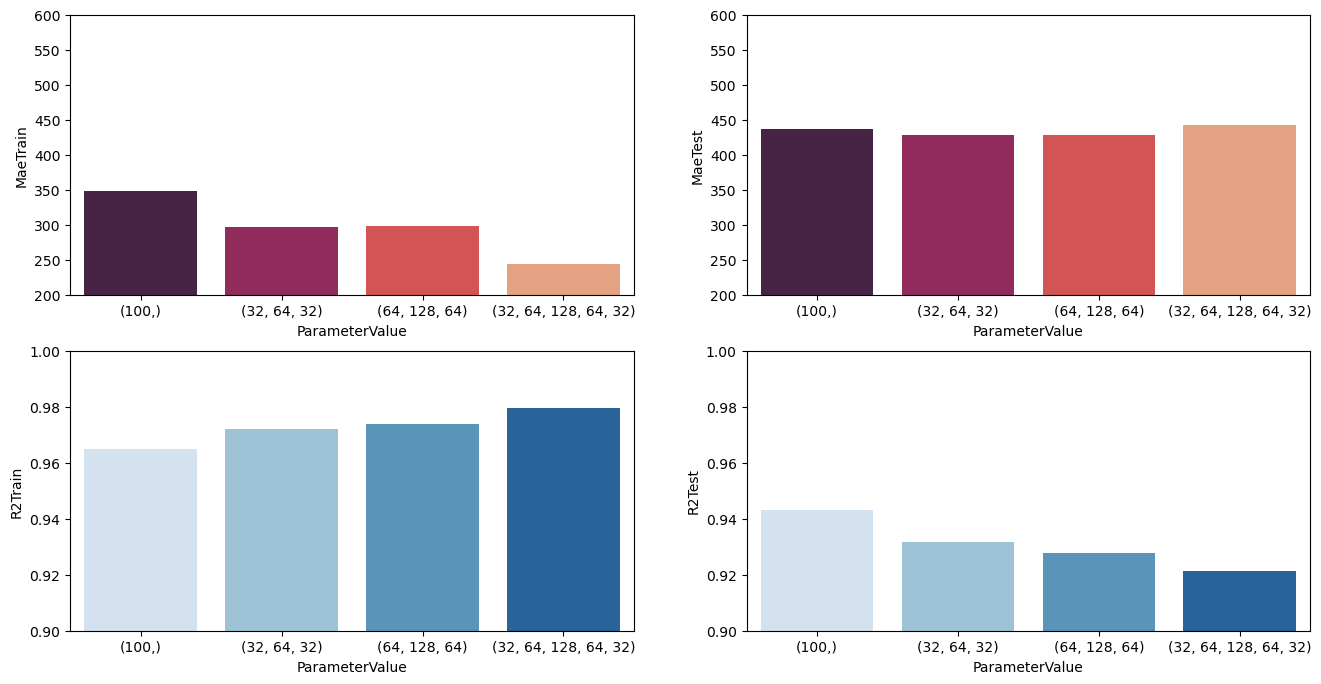

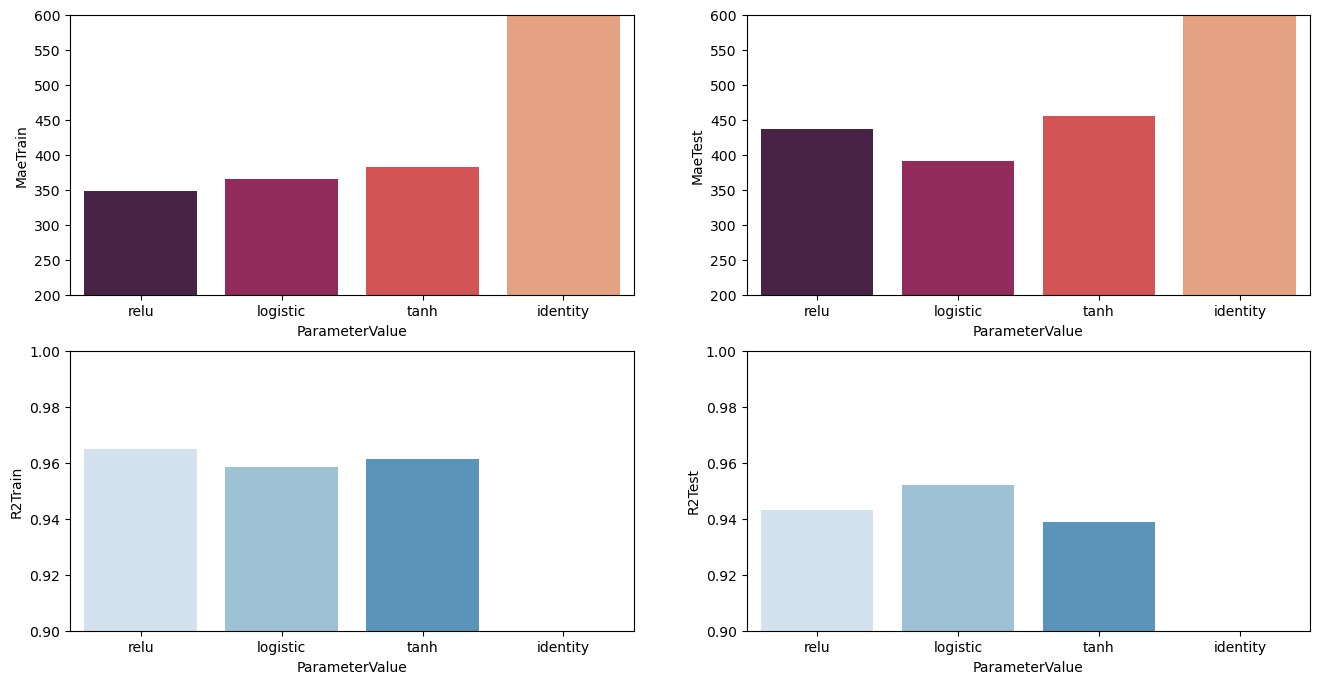

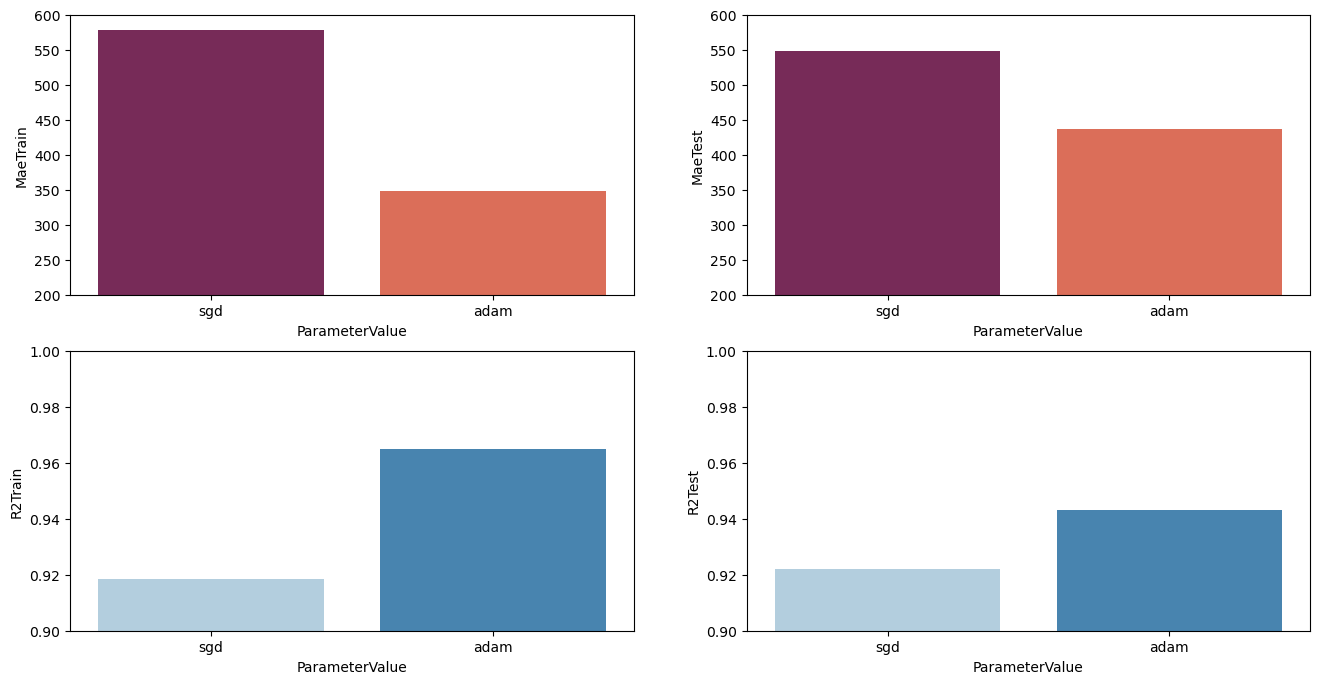

In [52]:
# defining a function for barplots for some of the parameters to compare mae and r2
def plot_bars(data_filter):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
    plot_data = param_testing[param_testing["Parameter"] == data_filter]

    mae_train_axes = axes[0, 0]
    sns.barplot(data=plot_data, x="ParameterValue", y="MaeTrain", ax=mae_train_axes, palette="rocket")
    mae_train_axes.set_ylim(200, 600)

    mae_test_axes = axes[0, 1]
    sns.barplot(data=plot_data, x="ParameterValue", y="MaeTest", ax=mae_test_axes, palette="rocket")
    mae_test_axes.set_ylim(200, 600)

    r2_train_axes = axes[1, 0]
    sns.barplot(data=plot_data, x="ParameterValue", y="R2Train", ax=r2_train_axes, palette="Blues")
    r2_train_axes.set_ylim(0.9, 1)

    r2_test_axes = axes[1, 1]
    sns.barplot(data=plot_data, x="ParameterValue", y="R2Test", ax=r2_test_axes, palette="Blues")
    r2_test_axes.set_ylim(0.9, 1)

# apply the function to wanted parameters for comparison
plot_bars("hidden_layer_size")
plot_bars("activation")
plot_bars("solver")

*Interpretation:* <br> - Hidden Layers: It can be seen that "(100,)" or "(32, 64, 32)" are the best parameters while analyzing MAE and R^2 <br> - Activation: Clearly "Relu" or "Logistic" should be used as an activation function. <br> - Solver: "Adam" is the better solver on the training an the testing data.

In [ ]:
# defining a function for lineplots for some of the parameters to compare mae and r2
def plot_lines(data_filter):
    fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
    plot_data = param_testing[param_testing["Parameter"] == data_filter]
    plot_data = pd.melt(plot_data, id_vars=["Parameter", "ParameterValue"], var_name="Measure", 
    value_vars=["MaeTrain", "MaeTest", "R2Train", "R2Test"], value_name="MeasuredValue")

    mae_data = plot_data[plot_data["Measure"].isin(["MaeTrain", "MaeTest"])]
    mae_axes = axes[0]
    sns.lineplot(data=mae_data, x="ParameterValue", y="MeasuredValue", hue="Measure", ax=mae_axes, palette="rocket")
    mae_axes.set_xticks([0, 24, 49])

    r2_data = plot_data[plot_data["Measure"].isin(["R2Train", "R2Test"])]
    r2_axes = axes[1]
    sns.lineplot(data=r2_data, x="ParameterValue", y="MeasuredValue", hue="Measure", ax=r2_axes, palette="Blues")
    r2_axes.set_xticks([0, 24, 49])

# apply the function to wanted parameters for comparison
plot_lines("alpha")
plot_lines("learning_rate_init")
plot_lines("max_iter")

*Interpretation:* <br> - Alpha: It should be somewhere in the middle of 0.00001 and 0.001, so the default value of 0.0001 doesn't seem to be too bad <br> - Learning Rate: A good learning rate seems to be around 0.001, like the default value. Maybe we should event try something smaller <br> - Iterations: There is no different in using 1000 or 2000 iterations. We try it nevertheless to find out if it is influenced by other parameters.

*3. Trying to optimize the Hyperparameters of the neural network using the findings above*
1. The optimal tuning of the hyperparameters would normally be done with the whole dataset. This would take for this project far too long to calculate. Therefore the data is subsetted and 10% of the data is used for the hyperparameter tuning. 
2. First using RandomizedSearchCV on the subset to find a good starting point for each parameter.
3. With the results use GridSearchCV and conduct an analysis in a range around the found parameters.

In [11]:
# subsetting the data for the optimization of the hyperparameters
ped_subset = ped.sample(frac=0.1, random_state=1)

# Define a new X of the subset with the squared feature k = 0.99, 57+46
X_subset = np.array(ped_subset[ped_subset.columns[57:103]])

# Subset of the output to predict
y_subset = ped_subset["pedestrians count"]

# Split the subset into train and test sets
Xtrain_subset, Xtest_subset, ytrain_subset, ytest_subset = train_test_split(
    X_subset, y_subset, test_size=0.3, random_state=72)

In [12]:
# scale the data of the subset, so it is less sensitive to feature scaling 
# scale the inputs
scaler.fit(Xtrain_subset)
Xtrain_scaled_subset = scaler.transform(Xtrain_subset)
# apply the same transformation to the test data to have meaningful results
scaler.fit(Xtest_subset)
Xtest_scaled_subset = scaler.transform(Xtest_subset)
# scale the y different because we can't use standardscaler to a 1d array
mu_subset, sigma_subset = y_subset.mean(), y_subset.std()
ytest_scaled_subset = (ytest_subset - mu_subset) / sigma_subset
ytrain_scaled_subset = (ytrain_subset - mu_subset) /sigma_subset

In [13]:
# defining the model and the parameters used in RandomizedSearchCV
nnet_randomsearch = MLPRegressor(random_state=72)

parameters_randomsearch = {
    "hidden_layer_sizes": [(50,), (100,), (150,), (9, 18, 6), (32, 64, 32), (12, 24, 12)],
    "activation": ["logistic", "relu"],
    "solver": ["adam"],
    "alpha": np.linspace(0.00005, 0.0005, 20),
    "learning_rate_init" : np.linspace(0.0005, 0.001, 20),
    "max_iter" : range(1000, 2000, 100)
}

In [ ]:
# running the RandomizedSearchCV on the subset of the data
nnet_rndm_src = RandomizedSearchCV(estimator=nnet_randomsearch, param_distributions=parameters_randomsearch, cv=2)
nnet_rndm_src.fit(Xtrain_subset, ytrain_subset)
nnet_rndm_src.best_params_

*results:* <br> {'solver': 'adam', <br>
 'max_iter': 1400, <br>
 'learning_rate_init': 0.0006052631578947369, <br>
 'hidden_layer_sizes': (9, 18, 6), <br>
 'alpha': 0.00047631578947368423, <br>
 'activation': 'relu'}


In [14]:
# creating a neural network with those results and the whole data and look at mae and r2
nnet_random = MLPRegressor(hidden_layer_sizes=(9, 18, 6), activation="relu", solver="adam", alpha=0.00047631578947368423,
    learning_rate_init=0.0006052631578947369, max_iter=1400, random_state=72)

# fit the data and run the model with new parameters
model_fit_evaluate("RandomSearch", nnet_random, Xtrain_scaled, ytrain_scaled, Xtest_scaled, ytest_scaled)

           Model   MAE_train    MAE_test  R2_train   R2_test
0  Base Scenario  347.447001  456.576090  0.964814  0.942335
1   RandomSearch  392.851111  410.187292  0.949453  0.947754


In [16]:
# use GridSearchCV to further optimize the parameters and run now all possibilities
# defining the model and the parameters used in GridSearchCV
nnet_gridsearch = MLPRegressor(random_state=72)

parameters_gridsearch = {
    "hidden_layer_sizes": [(9, 18, 6), (32, 64, 32)], # keeping (32, 64, 32) because it looked promising before and compare it to randomized optimum
    "activation": ["relu"],
    "solver": ["adam"],
    "alpha": np.linspace(0.0003, 0.0005, 3),
    "learning_rate_init" : np.linspace(0.0005, 0.0007, 3),
    "max_iter" : range(1300, 1600, 100)
}


In [18]:
# running the GridSearchCV on the subset of the data
nnet_grid_src = GridSearchCV(estimator=nnet_gridsearch, param_grid=parameters_gridsearch, cv=2)
nnet_grid_src.fit(Xtrain_subset, ytrain_subset)
nnet_grid_src.best_params_

c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\en

{'activation': 'relu',
 'alpha': 0.0003,
 'hidden_layer_sizes': (32, 64, 32),
 'learning_rate_init': 0.0005,
 'max_iter': 1300,
 'solver': 'adam'}

*Results:* <br> {'activation': 'relu', <br>
 'alpha': 0.0003, <br>
 'hidden_layer_sizes': (32, 64, 32), <br>
 'learning_rate_init': 0.0005, <br>
 'max_iter': 1300, <br>
 'solver': 'adam'}

In [99]:
# creating a neural network with those results and the whole data and look at mae and r2
nnet_grid = MLPRegressor(hidden_layer_sizes=(32, 64, 32), activation="relu", solver="adam", alpha=0.0003,
    learning_rate_init=0.0005, max_iter=1300, random_state=72)

# fit the data and run the model with new parameters
model_fit_evaluate("GridSearch", nnet_grid, Xtrain_scaled, ytrain_scaled, Xtest_scaled, ytest_scaled)

        Model   MAE_train   MAE_test  R2_train  R2_test
0  GridSearch  321.755799  442.35177  0.968152  0.93483


**Comparing the results of the 3 neural networks**

In [82]:
# reading the created dataframe and have a look at it to plot it later for the analysis
comparison = pd.read_csv("nnet_comparison.csv", sep=";")
comparison

,Model,MAE_train,MAE_test,R2_train,R2_test
0,Base Scenario,347.447001,456.576090,0.964814,0.942335
1,RandomSearch,392.851111,410.187292,0.949453,0.947754
2,GridSearch,321.755799,442.351770,0.968152,0.934830


(0.9, 1.0)

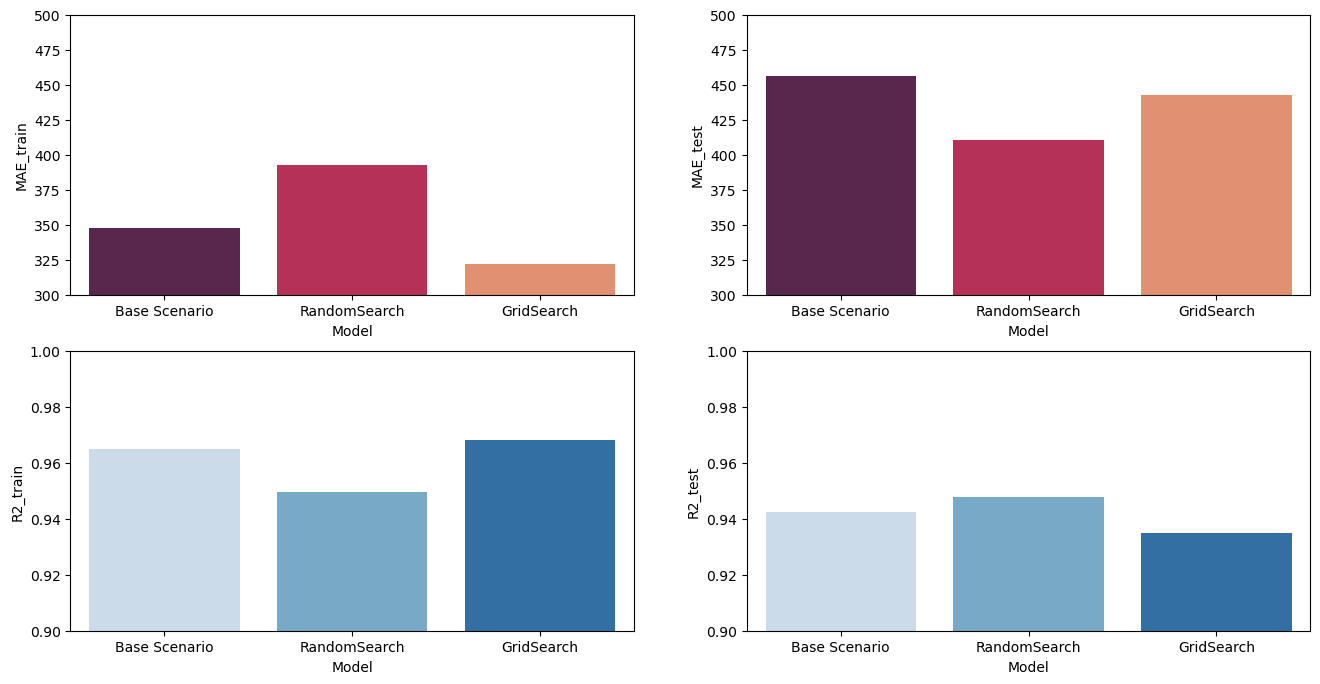

In [94]:
# plotting the comparison
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

mae_train_axes = axes[0, 0]
sns.barplot(data=comparison, x="Model", y="MAE_train", ax=mae_train_axes, palette="rocket")
mae_train_axes.set_ylim(300, 500)

mae_test_axes = axes[0, 1]
sns.barplot(data=comparison, x="Model", y="MAE_test", ax=mae_test_axes, palette="rocket")
mae_test_axes.set_ylim(300, 500)

r2_train_axes = axes[1, 0]
sns.barplot(data=comparison, x="Model", y="R2_train", ax=r2_train_axes, palette="Blues")
r2_train_axes.set_ylim(0.9, 1.0)

r2_test_axes = axes[1, 1]
sns.barplot(data=comparison, x="Model", y="R2_test", ax=r2_test_axes, palette="Blues")
r2_test_axes.set_ylim(0.9, 1.0)

*Interpretation:* <br> The RandomSearch model performs the best which we can see with the lowest MAE and highest R^2 on the test data

**Plotting the Final Model with Predictions**

NameError: name 'ypred' is not defined

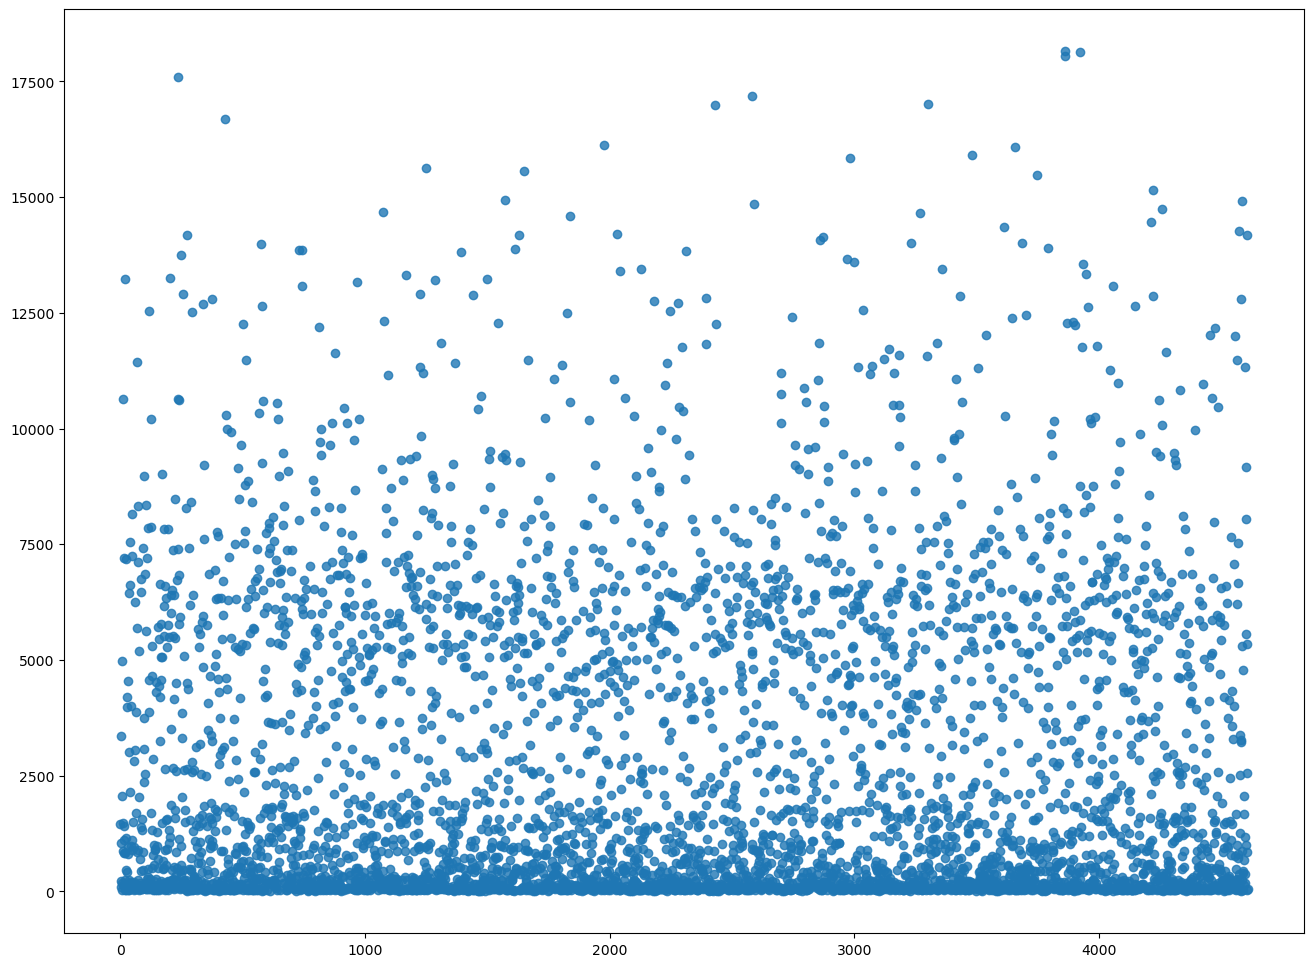

In [100]:
# plot the results to see the results of our base scenario
fig, ax = plt.subplots(figsize=(16, 12))

#create a linspace to match the y-values
xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

# plot the true values for 2 pca variables
ax.scatter(xs, ytest, label="true values", alpha=0.8)

# plot the predictions
ax.scatter(xs, ypred, label="predictions", color = "red", alpha=0.2)

# Add labels and legend
ax.set_ylabel("Pedestrians")
ax.legend()